In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Mini Project 1: The Travelling Salesman 

In this notebook, you will find the guidelines to complete your mini-project 1 on the travelling salesman problem. 


As illustrated in the lecture, simulated annealing is a probablistic approach used for finding a solution to an optimization problem. In this mini project you implement
a simulated annealing Python code applied to the Travelling Salesman Problem (TSP).

Typically, the TSP is an optimization problem that seeks to find the shortest path passing through every city exactly once. In our example the TSP path is defined to start and end in the same city (so the path is a closed loop).

### before leaving the room, if anything is not clear with the starting example code, the setup of the problem, or the general content of the report then please speak to a TA for clarification


## Overview of the Mini project

In this project we will :

  0. construct the `simulated_annealing` function 
  0. write a pairwise swap move  
  0. Complete a temperature `schedule` function to define the temperature profile
  0. Use the obtained algorithm to solve the TSP on a generated map of random points
  0. Extend this method to the realistic case of US capitals on a map
  0. Answer the open questions at the end of the notebook


### Import the Numpy and Matplotlib modules

As we practiced in the past notebooks, we import here the relevant modules. 






In [ ]:
import numpy as np  
import numpy.random as random  
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline



### Python and matplotlib versions

Some students have reported issues when running the notebook examples with python 3.10. Please document here and in the report the version of python and matplotlib you are using on your system. 

In [ ]:
import sys
import matplotlib 
print("Python version: {}".format(sys.version))
print("Matplotlib version: {}".format(matplotlib.__version__))

Python version: 3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]
Matplotlib version: 3.2.2



### List of US capitals

To base our approach on a realistic question, we use here the map services and data available from U.S. Geological Survey, National Geospatial Program.
If interested, see https://www.usgs.gov/information-policies-and-instructions/usgs-visual-identity-system for further information.

We provide on KEATS both a map (map.png) and a list of the US capitals
(capitals.json). Please save those two files at the same location as this Python Notebook. 
We will make use in this notebook of a few additional modules that will help with
showing the path on the US map. 

These are not key to the understanding of the assignment, but will be helpful in visualising your results.

We start by importing the US map as an image file:


In [ ]:
import json
import copy

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

map = mpimg.imread("/content/gdrive/MyDrive/map.png")  



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


We load the file "capitals.json", e.g. the list of US cities, into a list named `capitals_list` : 







In [ ]:
# List of 30 US state capitals and corresponding coordinates on the map

with open('/content/gdrive/MyDrive/capitals.json', 'r') as capitals_file:
    capitals = json.load(capitals_file)
    
    
capitals_list = list(capitals.items())

capitals_list = [(c[0], tuple(c[1])) for c in capitals_list]
# if this [ ... for ... in ... ] syntax is unfamilier look up python list comprehension 

print(capitals_list)

print("example : ")

print(capitals_list[0])


[('Oklahoma City', (392.8, 356.4)), ('Montgomery', (559.6, 404.8)), ('Saint Paul', (451.6, 186.0)), ('Trenton', (698.8, 239.6)), ('Salt Lake City', (204.0, 243.2)), ('Columbus', (590.8, 263.2)), ('Austin', (389.2, 448.4)), ('Phoenix', (179.6, 371.2)), ('Hartford', (719.6, 205.2)), ('Baton Rouge', (489.6, 442.0)), ('Salem', (80.0, 139.2)), ('Little Rock', (469.2, 367.2)), ('Richmond', (673.2, 293.6)), ('Jackson', (501.6, 409.6)), ('Des Moines', (447.6, 246.0)), ('Lansing', (563.6, 216.4)), ('Denver', (293.6, 274.0)), ('Boise', (159.6, 182.8)), ('Raleigh', (662.0, 328.8)), ('Atlanta', (585.6, 376.8)), ('Madison', (500.8, 217.6)), ('Indianapolis', (548.0, 272.8)), ('Nashville', (546.4, 336.8)), ('Columbia', (632.4, 364.8)), ('Providence', (735.2, 201.2)), ('Boston', (738.4, 190.8)), ('Tallahassee', (594.8, 434.8)), ('Sacramento', (68.4, 254.0)), ('Albany', (702.0, 193.6)), ('Harrisburg', (670.8, 244.0))]
example : 
('Oklahoma City', (392.8, 356.4))


**NOTE: The example given is not matched with the sequence index given. I modified those.**




A path connecting a set of cities can be defined as a simple list of these cities:

`path = [capitals_list[0],capitals_list[1],capitals_list[4]]`

In this example, we connect the first, second and fifth cities of the list (St Paul, Little Rock,
Salt Lake City).

We now define below a function `show path` that will allow you to overlay the chosen path on the map of the USA, and test your implementation of the TSP on a realistic example.


In [ ]:
def coord(path):
        """Strip the city name from each element of the path list and return
        a list of tuples containing only pairs of xy coordinates for the
        cities. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> [(585.6, 376.8), ...]
        """
        _, coord = path
        return coord

def coords(path):
        """Strip the city name from each element of the path list and return
        a list of tuples containing only pairs of xy coordinates for the
        cities. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> [(585.6, 376.8), ...]
        """
        _, coords = zip(*path)
        return coords
    
def show_path(path_, starting_city, w=35, h=15):
    """Plot a TSP path overlaid on a map of the US States & their capitals."""
    path=coords(path_) 
    x, y = list(zip(*path))
    
    _, (x0, y0) = starting_city
    
    plt.imshow(map)
    plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point
    plt.plot(x + x[:1], y + y[:1])  # include the starting point at the end of path
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])
    


As an example, we show the path defined above:




[('Saint Paul', (451.6, 186.0)), ('Little Rock', (469.2, 367.2)), ('Salt Lake City', (204.0, 243.2))]


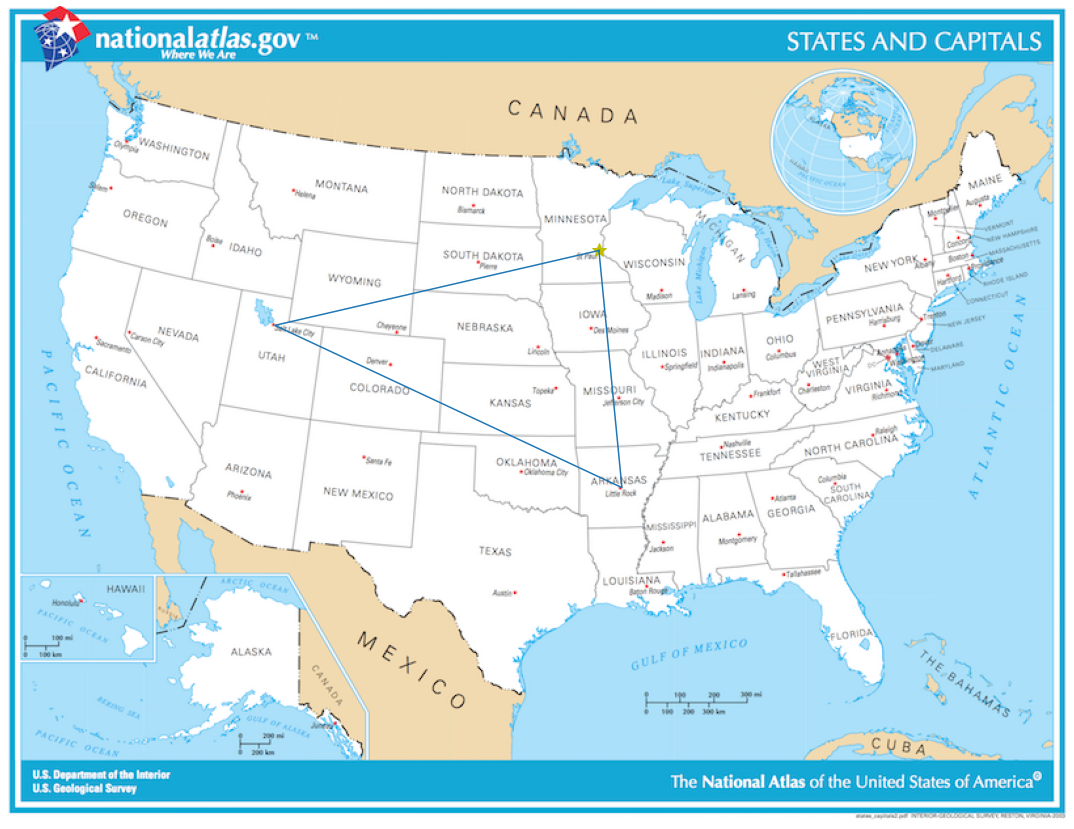

In [ ]:
path = [capitals_list[2],capitals_list[11],capitals_list[4]]

print(path)

show_path(path,capitals_list[2])

In [ ]:
len(capitals_list)

30

## Simulated Annealing -- The algorithm

Here, we want to implement the main loop of the simulated annealing algorithm. 

We will repeatedly swap pairs of cities and consider accepting or rejecting such
a modification, in accordance to a probability function $P$ :

$$ P = e^{ - \left( d_{new} - d_{old}  \right) / T } $$

where $d_{new}$ and $d_{old}$ are respectively the new and old overall path length, and $T$ is a "temperature". Note of course that $T$ is not a physical temperature, but a control parameter that determines how likely we are to accept or reject this move. 

The simulated annealing algorithm is a version of a stochastic hill climbing (the top of the hill is the shortest path length)
where some downhill moves are allowed. Downhill moves (moves that lead to a longer path length) are accepted readily
early in the annealing schedule and then less often as time goes on. 

In other words, we will ask you to start accepting and rejecting moves with a high temperature,
and slowly reduce the temperature present in the simulation as times goes on. This is called a temperature schedule. 

The schedule input determines the value of the temperature T as a function of time. 










## Problem 1 :  Define the Temperature Schedule

The most common temperature schedule is simple exponential decay: 

$$T(t) = \alpha^t T_0$$

In most cases, the valid range for temperature $T_0$ can be very high (e.g., 1e8 or higher), and the _decay parameter_ $\alpha$ should be close to, but less than 1.0 (e.g., 0.95 or 0.99).  Think about the ways these parameters effect the simulated annealing function.  Try experimenting with both parameters to see how it changes runtime and the quality of solutions. 

You can also experiment with other schedule functions -- linear, quadratic, etc.  Think about the ways that changing the form of the temperature schedule changes the behavior and results of the simulated annealing function.

Remember to include the code (as new code blocks and plot outputs) and results (as markdown blocks) from these investigations--this applies throughout the report. If it is not included we can't give marks for it.

In the following cell, define a function that takes the time $t$ as an argument, and returns
the temperature as an output. Use default values for the parameters $\alpha$ and $T_0$, which should also be arguments of the function.






In [ ]:
import math
#to FILL
def temperature_origin(t, alpha = 0.95, t0 = 1e8):
    T = math.pow(alpha, t) * t0
    return T

def temperature_linear(t, alpha = 0.95, t0 = 1e8):
    T = t0 / (1 + alpha * t)
    return T

def temperature_quadratic(t, alpha = 0.95, t0 = 1e8):
    T = t0 / (1 + alpha * t * t)
    return T

def temperature_log(t, alpha = 0.95, t0 = 1e8):
    T = t0 / (1 + alpha * math.log(1 + t, 2))
    return T

## Problem 2 : Define a starting random path

In order to use simulated annealing we need to build a representation of the problem domain.  The choice of representation can have a significant impact on the performance of simulated annealing and other optimization techniques.  Since the TSP deals with a close loop that visits each city in a list once, we will represent each city by a tuple containing the city name and its position specified by an (x,y) location on a grid. The path is defined as the sequence generated by traveling from each city in the list to the next in order.

Note that in the example above, `capital_cities` is a list that contains the cities, both their names and their coordinates. 

For example, a chosen path could be:

`path_start = [ capitals_list[0], capitals_list[2], capitals_list[5] ]` 

The associated geographic coordinates can be obtained by the function `coords( city_list  )`, which returns a list of the coordinates for the path, or similarly, by the function `coord( city )`, which returns the coordinates of a single city.





In [ ]:
print("coordinate of the city capital_cities[2] : ")

print( coord ( capitals_list[2] ) )  


coordinate of the city capital_cities[2] : 
(451.6, 186.0)


Define in the cell below a function which generates a random path that connects 8 cities, and passes only once by each cities





In [ ]:

#TO FILL 
import random

def initial_path(c_list, capital_num = 8, Cap_num = 30):
    L = random.sample(range(0, Cap_num), capital_num)
    #print(L)
    cap_list = []
    for i in L:
        cap_list.append(c_list[i])
    return cap_list



## Problem 3 : Pair-wise exchange

In order to apply the simulated annealing algorithm, we will need to perform pair-wise exchange of 
cities along the path. Define in the cell below a function that takes a path as an argument, and returns another path, where two given cities have been swapped. 

For this function, you might have to copy a list in Python.

Note that the simple operation: `list2 = list1` will not formally operate a copy of list1 to a new object list2 (if you modify list2, it will also modify list1, the two object are related).

To create a new independent list as an actual copy, use instead:

`list2=list1.copy()` 

Hint: pay attention to the cyclic nature of the problem. Here the last city is connected to the first one. You might use the modulo function in Python :

` x % y ` where x modulo y returns the remainder of the division of x by y. 

This funciton should accept as an input a given path, and return as an output a new path variable,
independent from the input. 



In [ ]:
#TO FILL 
def pair_wise(path, capital_num = 8):
    path2 = path.copy()
    #print(path2)
    L = random.sample(range(0, capital_num - 1), 2)
    pos1 = L[0]
    pos2 = L[1]
    #print(pos1, pos2)
    path2[pos1], path2[pos2] = path2[pos2], path2[pos1]
    #print(path2)
    return path2

## Problem 4 : Path length

In order to accept or reject the proposed pair wise exchange swap, we need to build a function which takes a given path as an argument, and returns the total length of the circular path. 
Write this function in the cell below. 

A tip here: You might want to create in Python a list of pairs of consecutive cities. This is very easily obtained given a list in Python:

` pair = zip ( list1, list1[1:] ) `

Beware of the last segment, which connects the last city to the first. This can easily
be treated by extending the list : 

` total_path = list( my_path ) + [ my_path[0] ] `

As we have seen this in the last Python notebooks, items can be added easily when dealing
with lists. Here the list is extended by adding the first city to the end of the overall
list of cities. 









In [ ]:
#TO FILL

def distance(x, y):
    p1 = coord (x)
    p2 = coord (y)

    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def path_length(c_list):
    pair = list(zip(c_list, c_list[1:]))
    total_path = list( pair ) + [ pair[0] ]
    sum_dis = 0
    for i in total_path:
        sum_dis = sum_dis + distance(i[0], i[1])
    return sum_dis

In [ ]:
c_list = initial_path(capitals_list)
path_length(c_list)

[9, 0, 6, 5, 8, 1, 12, 7]


1679.962088959126

## Problem 5 : Simulated annealing

We will now merge together the elements of code generated above. Write below the following algorithm :

0. generates a random path for 8 cities
0. define a starting temperature $T_0$
0. perform an attempted pair wise exchange
0. for each attempt, accepts or rejects with a probability $P$, defined as 

$$ P = e^{ - \left( d_{new} - d_{old}  \right) / T } $$

0. If accepted, modify the path
0. In any case, update the temperature according to the temperature profile (see your temperature function defined above)
0. Print the obtained distance
0. Go to step (3), repeat for 200 attempts 


Start with the following parameters: 

$\alpha = 0.97$

$T_0=1000$

N=8 (Number of cities) 

and 200 time steps (number of attempts)

Produce a plot of the obtained distance in function of the temperature, using log-log scales.
In Python, you can set log scales with the following syntax:

`plt.xscale("log")`

`plt.yscale("log")`

Repeat with different choices of $\alpha$, typically $\alpha=0.95,0.9,0.8$. Explore the behavior of the algorithm. 

Show the obtained travelling salesman trajectory on the US map for your chosen cities.

Repeat now with 20 cities, and then for all cities provides in `capitals_list`. 





In [ ]:
#TO FILL

def Simulated_annealing(capitals_list = capitals_list, alpha = 0.97, T0 = 1000, N = 8, time_step = 200, temperature_method = 'temperature_origin', cap_num = 30):
    path = initial_path(capitals_list, N, cap_num)
    start_city = path[0]
    length = []
    temperature = []
    for i in range(time_step): #we set the end temperature larger than 0
        temperature.append(T0)
        potential_path = pair_wise(path)
        delta = -(path_length(potential_path) - path_length(path))/T0
        if delta > 0: #accept
            path = potential_path
        else:
            P = math.exp(delta)
            if random.random()<P: #accept
                path = potential_path
        if temperature_method == 'temperature_origin':
            T0 = temperature_origin(i + 1, alpha, T0)
        elif temperature_method == 'temperature_linear':
            T0 = temperature_linear(i + 1, alpha, T0)
        elif temperature_method == 'temperature_quadratic':
            T0 = temperature_quadratic(i + 1, alpha, T0)
        elif temperature_method == 'temperature_log':
            T0 = temperature_log(i + 1, alpha, T0)
        
        #print(T0)
        print(path_length(path))
        length.append(path_length(path))
        if T0 <= 0:
            break

    x = list(np.log(temperature))
    y = list(np.log(length))
    
    plt.xscale("log")
    plt.gca().invert_xaxis()#since temperature is decreasing
    plt.yscale("log")
    
    plt.plot(x, y) 
    plt.show()
    return path, start_city


[('Trenton', (698.8, 239.6)), ('Salt Lake City', (204.0, 243.2)), ('Oklahoma City', (392.8, 356.4)), ('Hartford', (719.6, 205.2)), ('Richmond', (673.2, 293.6)), ('Des Moines', (447.6, 246.0)), ('Madison', (500.8, 217.6)), ('Saint Paul', (451.6, 186.0))]
1896.8113251285617
1359.6769674032562
2108.961576843065
2170.8228782392525
1576.2619999254532
1576.2619999254532
1576.2619999254532
1576.2619999254532
1536.0578174362304
1536.0578174362304
1520.5116701255547
1700.9180563006578
1520.5116701255547
1520.5116701255547
1520.5116701255547
1520.5116701255547
1520.5116701255547
1137.4279910598318
1137.4279910598318
1137.6006924894903
1137.6006924894903
1137.6006924894903
1137.6006924894903
1137.6006924894903
1137.6006924894903
1137.6006924894903
1137.6006924894903
1137.6006924894903
1137.6006924894903
1137.6006924894903
1133.2413673898443
1078.9971832301046
1078.9971832301046
1078.9971832301046
1078.9971832301046
1078.9971832301046
1078.9971832301046
1078.9971832301046
1078.9971832301046
1078.9

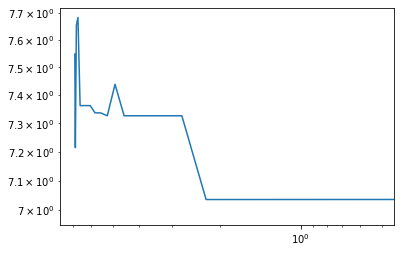

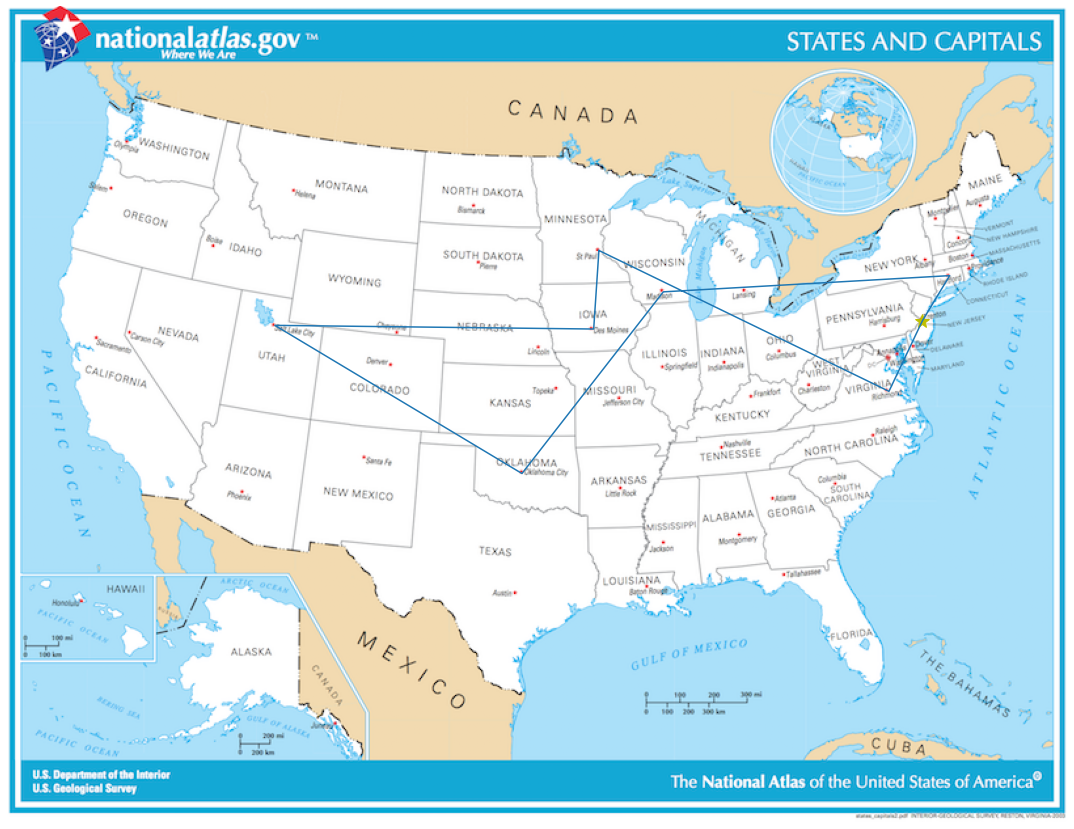

In [ ]:
#I set one strating point for comparison
start = initial_path(capitals_list, 8)
print(start)
path, start_city = Simulated_annealing(capitals_list = start, cap_num = 8)
show_path(path,start_city)

1711.0154337035917
1567.2903653121407
2069.5534907585866
2009.7910333784262
1907.5910139865236
1913.6725621173155
2130.2039567060133
2130.2039567060133
1195.3096769185272
1195.3096769185272
1290.0832292914017
1290.0832292914017
1299.8771490339132
1299.8771490339132
1290.0832292914017
1290.0832292914017
1264.0854759626113
1264.0854759626113
1264.0854759626113
1264.0854759626113
1264.0854759626113
1264.0854759626113
1264.0854759626113
1264.0854759626113
1264.0854759626113
1264.0854759626113
1264.0854759626113
1264.0854759626113
1264.0854759626113
1223.58627464091
1223.58627464091
1223.58627464091
1223.58627464091
1211.2491740218968
1211.2491740218968
1211.2491740218968
1211.2491740218968
1211.2491740218968
1211.2491740218968
1211.2491740218968
1178.6998654717424
1178.6998654717424
1178.6998654717424
1178.6998654717424
1178.6998654717424
1178.6998654717424
1178.6998654717424
1178.6998654717424
1178.6998654717424
1178.6998654717424
1178.6998654717424
1178.6998654717424
1178.6998654717424
1

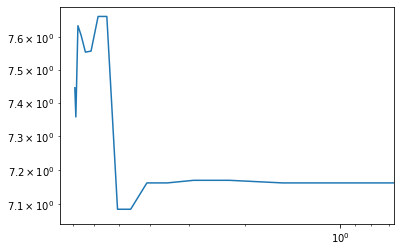

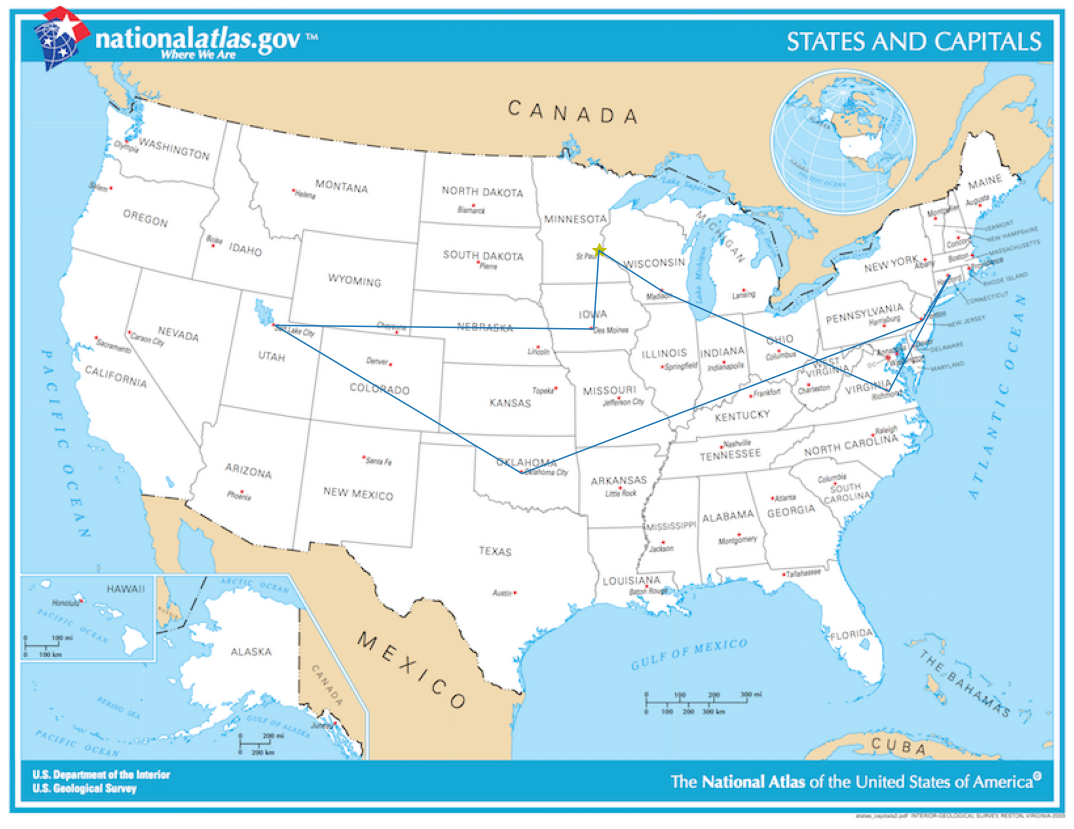

In [ ]:
path, start_city = Simulated_annealing(capitals_list = start, alpha = 0.95, cap_num = 8)
show_path(path,start_city)

1920.2093269552822
1916.5108709716908
2076.6372094408066
1161.1396899326514
1161.1396899326514
1114.6376031084449
1114.6376031084449
1114.6376031084449
1114.6376031084449
1114.6376031084449
1114.6376031084449
1114.6376031084449
1114.6376031084449
1114.6376031084449
1114.6376031084449
1114.6376031084449
1114.6376031084449
1114.6376031084449
1114.6376031084449
1114.6376031084449
1114.6376031084449
1114.6376031084449
1114.6376031084449
1114.6376031084449
1095.0762488386952
1095.0762488386952
1095.0762488386952
1095.0762488386952
1095.0762488386952
1095.0762488386952
1095.0762488386952
1095.0762488386952
1095.0762488386952
1034.8556429086711
1034.8556429086711
1034.8556429086711
1034.8556429086711
984.5516915827698
984.5516915827698
984.5516915827698
984.5516915827698
984.5516915827698
984.5516915827698
984.5516915827698
984.5516915827698
984.5516915827698
984.5516915827698
984.5516915827698
984.5516915827698
984.5516915827698
984.5516915827698
984.5516915827698
984.5516915827698
984.55169

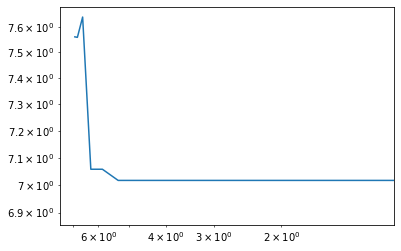

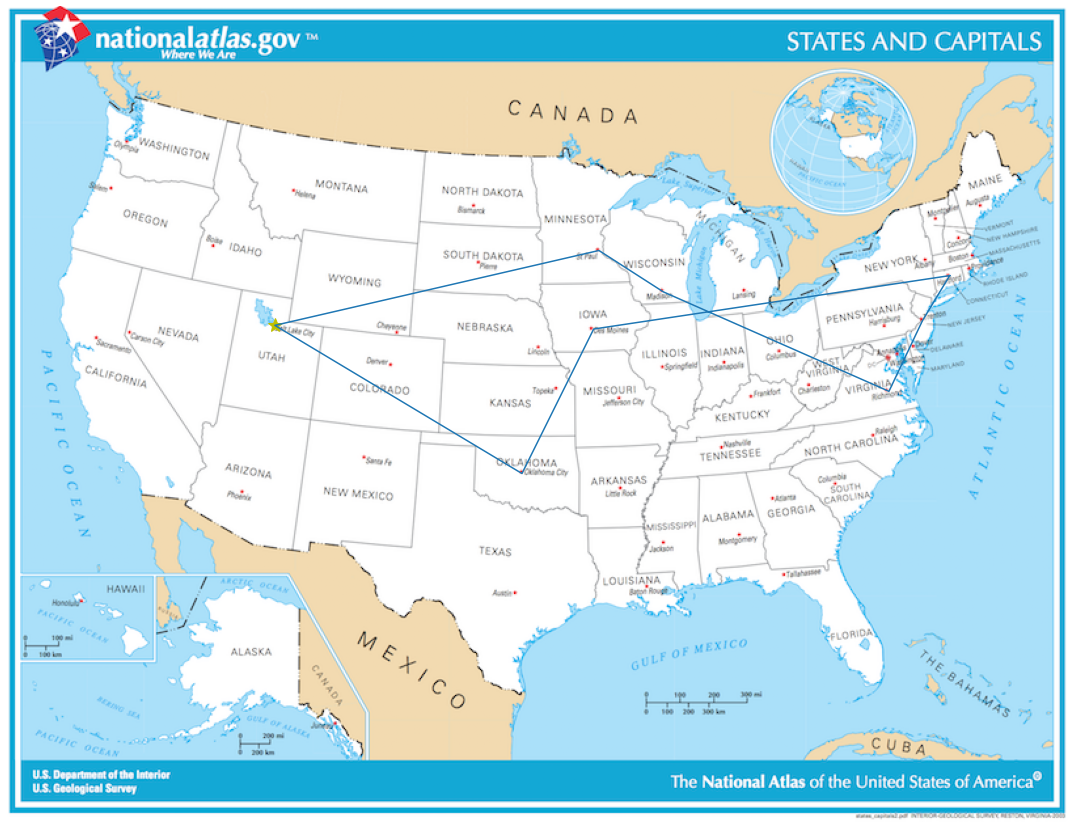

In [ ]:
path, start_city = Simulated_annealing(capitals_list = start, alpha = 0.9, cap_num = 8)
show_path(path,start_city)

1764.3237316016043
1903.3286486949203
1534.0967229935402
1640.98616539553
1655.0983410586
1655.0983410586
1601.5570921371611
1601.5570921371611
1601.5570921371611
1601.5570921371611
1340.0399133340577
1340.0399133340577
1340.0399133340577
1287.4248219832411
1270.611057632155
1270.611057632155
1178.3133047648016
1178.3133047648016
1178.3133047648016
1178.3133047648016
1178.3133047648016
1178.3133047648016
1178.3133047648016
1153.9793119273297
1147.8788839380807
1147.8788839380807
1147.8788839380807
1147.8788839380807
1049.1595835126038
1049.1595835126038
1049.1595835126038
1049.1595835126038
1049.1595835126038
1049.1595835126038
1049.1595835126038
1049.1595835126038
1049.1595835126038
1049.1595835126038
1049.1595835126038
1049.1595835126038
1049.1595835126038
1049.1595835126038
1049.1595835126038
1049.1595835126038
1049.1595835126038
1049.1595835126038
1049.1595835126038
1049.1595835126038
1049.1595835126038
1049.1595835126038
1049.1595835126038
1049.1595835126038
1049.1595835126038
104

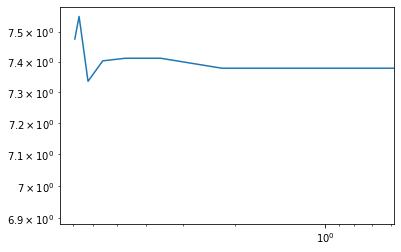

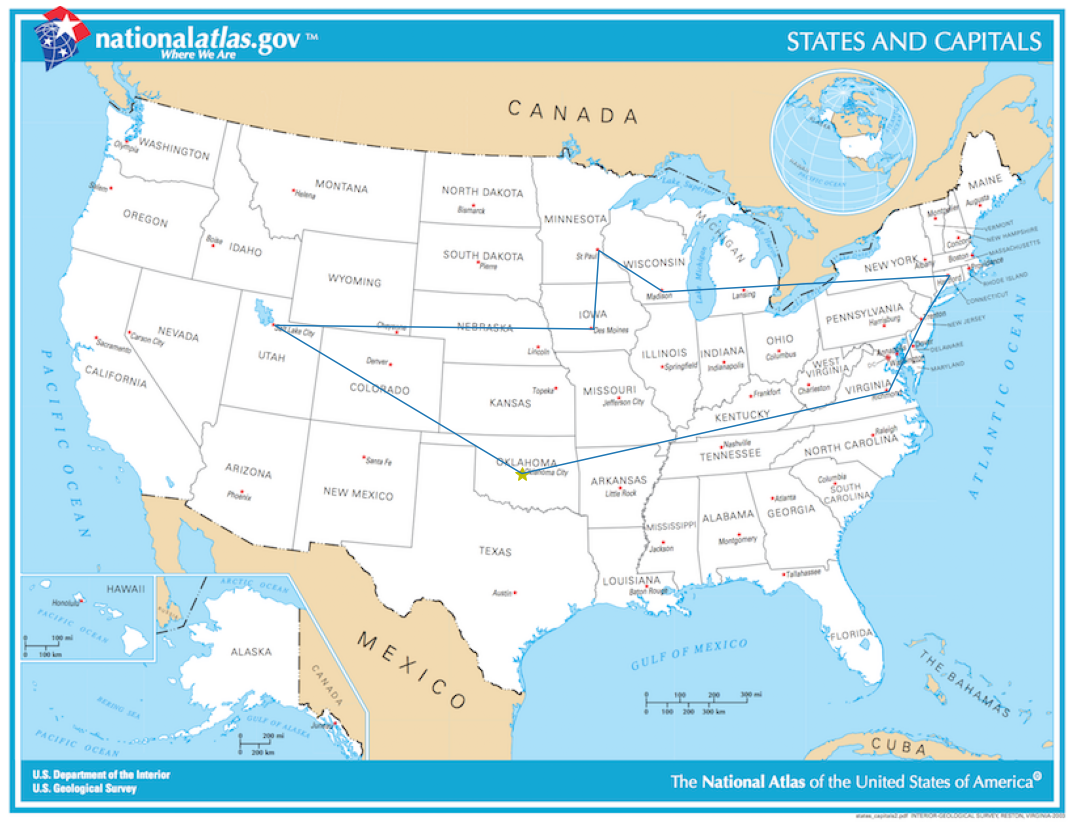

In [ ]:
path, start_city = Simulated_annealing(capitals_list = start, alpha = 0.8, cap_num = 8)
show_path(path,start_city)

2521.683794148378
2154.124015496463
2119.2428006982864
2119.2428006982864
1793.6840663555834
1793.6840663555834
1793.6840663555834
1498.0894433674298
1405.7916905000764
1405.7916905000764
1405.7916905000764
1405.7916905000764
1405.7916905000764
1405.7916905000764
1405.7916905000764
1405.7916905000764
1405.7916905000764
1405.7916905000764
1405.7916905000764
1405.7916905000764
1400.2387527773058
1400.2387527773058
1400.2387527773058
1400.2387527773058
1400.2387527773058
1400.2387527773058
1400.2387527773058
1400.2387527773058
1400.2387527773058
1400.2387527773058
1400.2387527773058
1257.1884965105592
1255.857477317543
1180.8853948542535
1180.8853948542535
1180.8853948542535
1180.8853948542535
1180.8853948542535
1180.8853948542535
1180.8853948542535
1180.8853948542535
1180.8853948542535
1180.8853948542535
1180.8853948542535
1180.8853948542535
1180.8853948542535
1180.8853948542535
1180.8853948542535
1180.8853948542535
1180.8853948542535
1180.8853948542535
1180.8853948542535
1180.8853948542

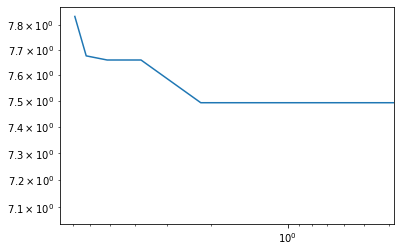

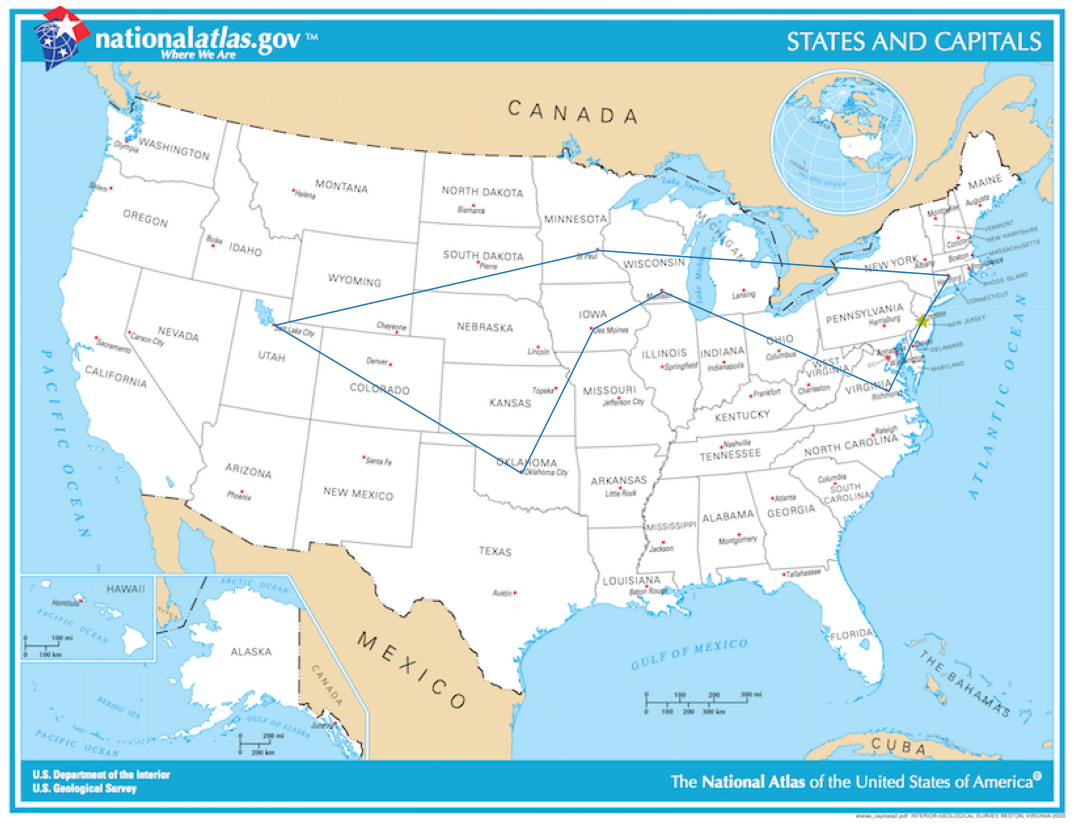

In [ ]:
path, start_city = Simulated_annealing(capitals_list = start, temperature_method = 'temperature_linear', cap_num = 8)
show_path(path,start_city)

1876.2965023321212
1876.2965023321212
1923.6406453009504
1757.724882488679
1590.445357259978
1490.6203017804032
1239.6838822751668
1239.6838822751668
1239.6838822751668
1225.9504542712452
1225.9504542712452
1225.9504542712452
1225.9504542712452
1225.9504542712452
1225.9504542712452
1225.9504542712452
1225.9504542712452
1225.9504542712452
1187.3121858028321
1187.3121858028321
1187.3121858028321
1187.3121858028321
1187.3121858028321
1187.3121858028321
1187.3121858028321
1187.3121858028321
1187.3121858028321
1187.3121858028321
1187.3121858028321
1187.3121858028321
1187.3121858028321
1187.3121858028321
1187.3121858028321
1187.3121858028321
1187.3121858028321
1167.1681910351842
1167.1681910351842
1167.1681910351842
1167.1681910351842
1167.1681910351842
1167.1681910351842
1167.1681910351842
1167.1681910351842
1167.1681910351842
1167.1681910351842
1167.1681910351842
1167.1681910351842
1167.1681910351842
1167.1681910351842
1167.1681910351842
1167.1681910351842
1167.1681910351842
1167.168191035

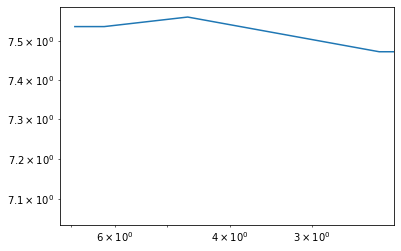

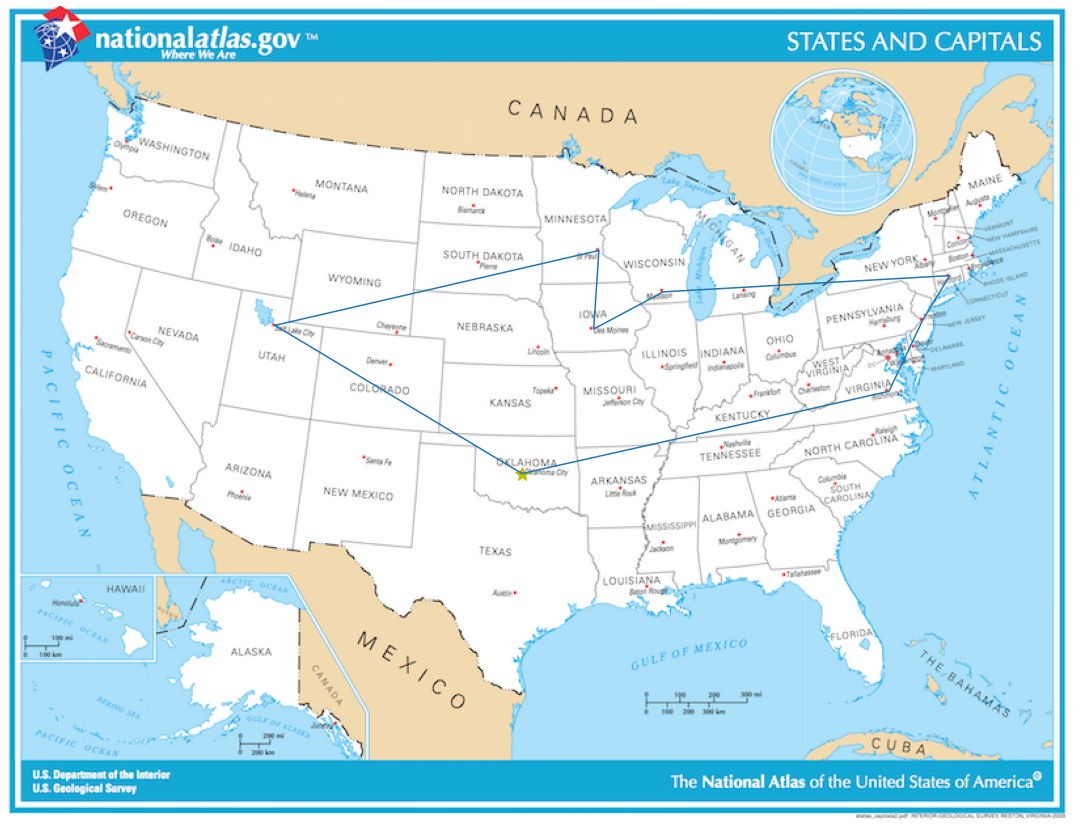

In [ ]:
path, start_city = Simulated_annealing(capitals_list = start, temperature_method = 'temperature_quadratic', cap_num = 8)
show_path(path,start_city)

1688.5486868167075
1675.4135566373996
1530.4448445939886
1473.437618280784
1473.437618280784
1473.437618280784
1473.437618280784
1419.0867989550939
1419.0867989550939
1419.0867989550939
1419.0867989550939
1419.0867989550939
1419.0867989550939
1419.0867989550939
1419.0867989550939
1419.0867989550939
1419.0867989550939
1419.0867989550939
1419.0867989550939
1419.0867989550939
1419.0867989550939
1419.0867989550939
1419.0867989550939
1419.0867989550939
1419.0867989550939
1419.0867989550939
1419.0867989550939
1419.0867989550939
1419.0867989550939
1419.0867989550939
1419.0867989550939
1419.0867989550939
1419.0867989550939
1409.1822175798027
1409.1822175798027
1409.1822175798027
1409.1822175798027
1409.1822175798027
1409.1822175798027
1409.1822175798027
1119.6075296061529
1119.6075296061529
1119.6075296061529
1119.6075296061529
1079.6814732111345
1079.6814732111345
1079.6814732111345
1010.0144344556832
1010.0144344556832
1010.0144344556832
1010.0144344556832
1010.0144344556832
1010.01443445568

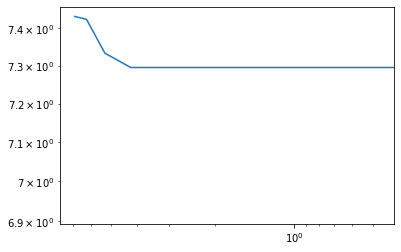

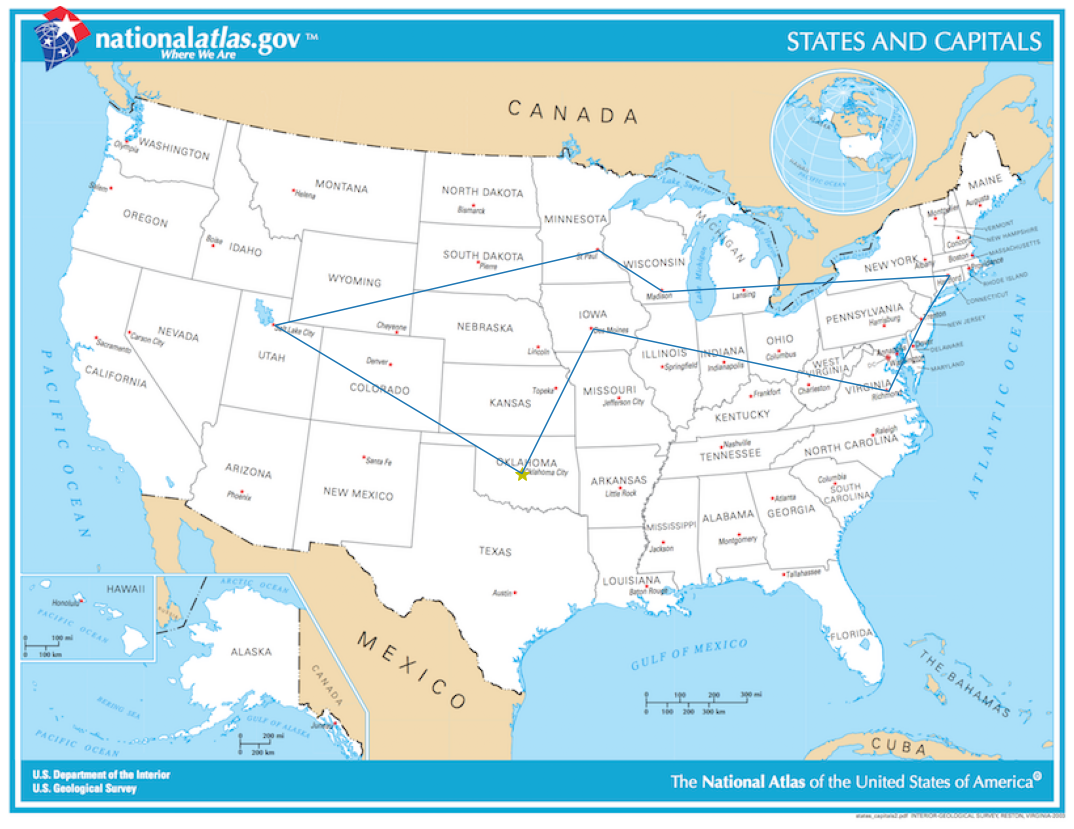

In [ ]:
path, start_city = Simulated_annealing(capitals_list = start, temperature_method = 'temperature_log', cap_num = 8)
show_path(path,start_city)

6408.656838736579
6036.167560876163
6103.375617065681
6003.166247002843
6173.324011278143
6228.499372439946
6255.906264994636
5655.0526779347365
5655.0526779347365
5484.606074555775
5484.606074555775
5484.606074555775
5484.606074555775
5484.606074555775
5484.606074555775
5484.606074555775
5484.606074555775
5484.606074555775
5484.606074555775
5484.606074555775
5484.606074555775
5484.606074555775
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40813595299
5319.40

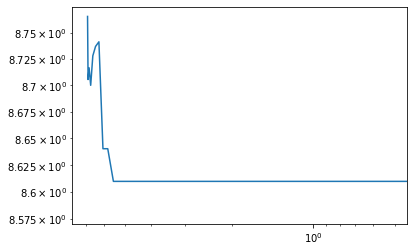

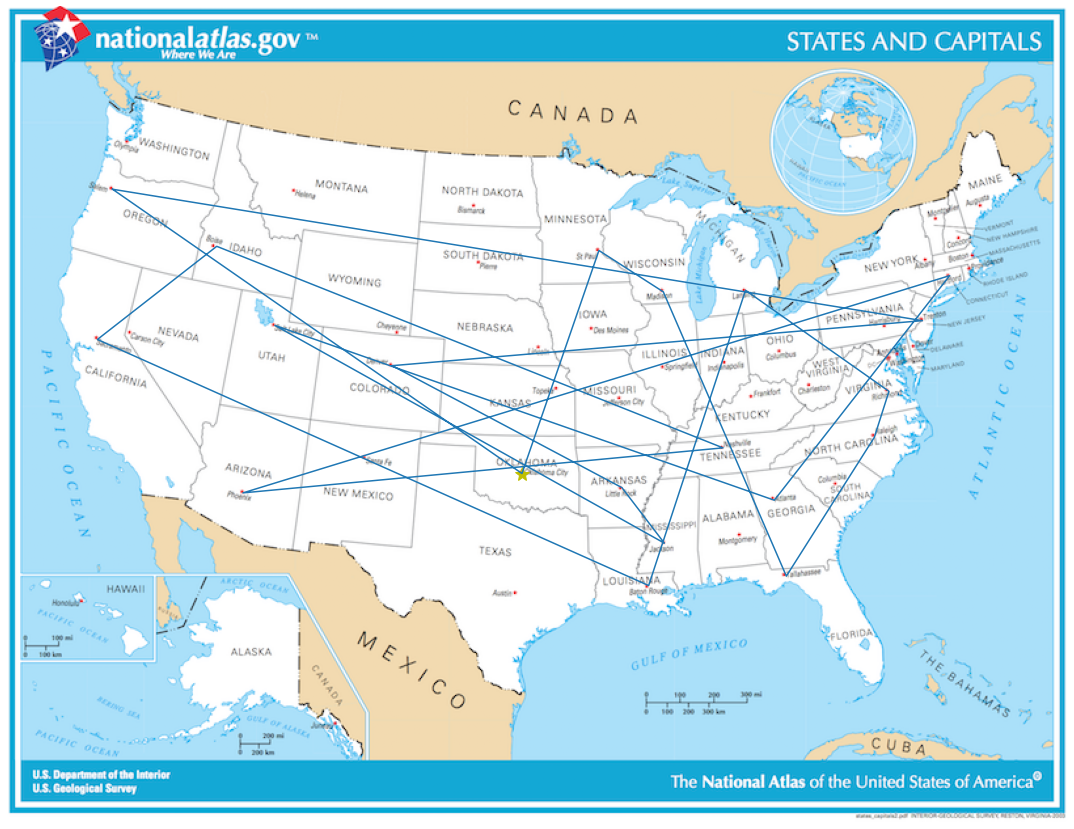

In [ ]:
path, start_city = Simulated_annealing(capitals_list = capitals_list, N = 20)
show_path(path,start_city)

7639.254567594147
7883.914227247215
7599.7243844074355
7720.348599567134
7542.01523969187
7929.030575381142
7924.260559825968
7924.260559825968
7536.815538639308
7536.815538639308
7541.585554194482
7541.585554194482
7541.585554194482
7541.585554194482
7333.783261781611
7273.312398375346
7273.312398375346
7273.312398375346
7273.312398375346
7273.312398375346
7273.312398375346
7201.953499673619
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.935402427319
7140.93540

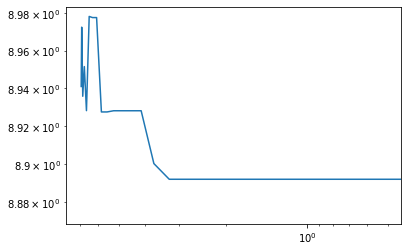

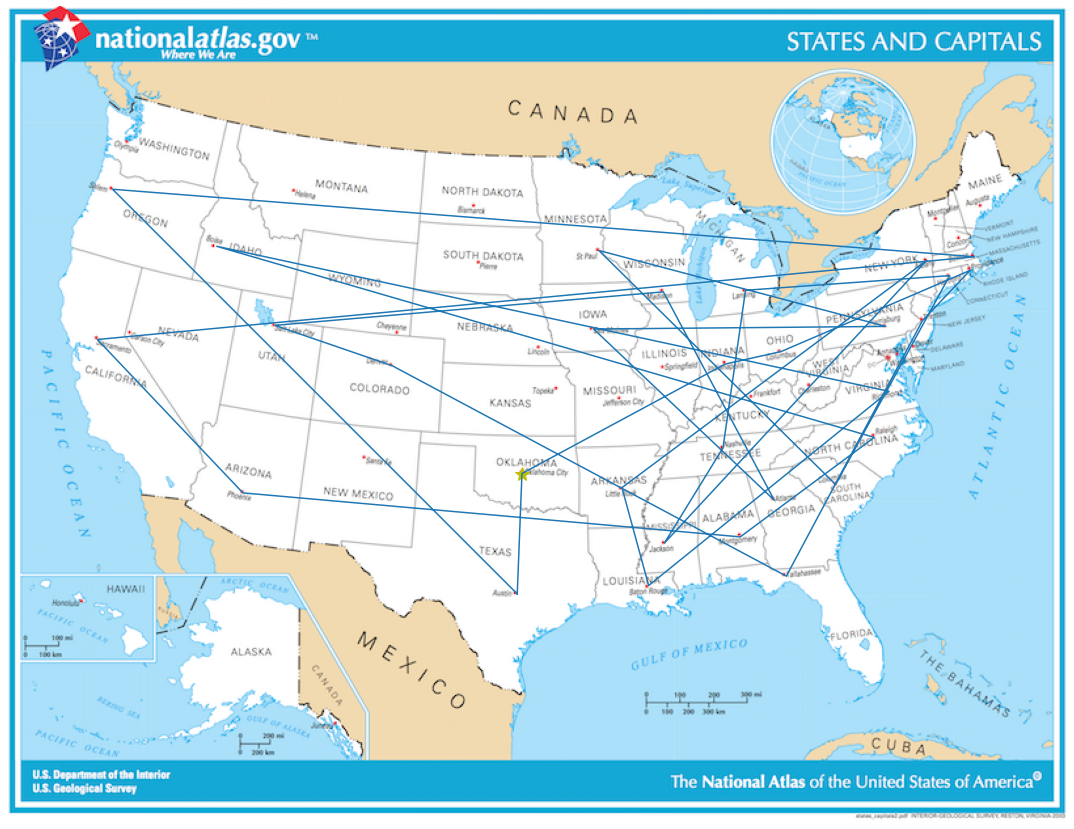

In [ ]:
path, start_city = Simulated_annealing(capitals_list = capitals_list, N = 30)
show_path(path,start_city)

## Problem 6 : Local minima and searching


Now that the algorithm is set, we want to obtain the absolute best path for all 30 capital cities. Repeat the simulated annealing 20 times with the optimal set of parameters that you have identified. 

Store for each attempt the best distance, and the optimal path. Propose a final solution to the problem, you can of course compare with the solutions obtained by other students but you should not be discussing your implementation or sharing or copying code.







In [ ]:
#TO FILL

def searching_best(repeated_time = 20):
    optim_path = initial_path(capitals_list, 30, 30)
    optim_value = path_length(optim_path)
    for i in range(repeated_time):
        path, start_city = Simulated_annealing(capitals_list = capitals_list, N = 30)
        if(optim_value > path_length(path)):
            optim_value = path_length(path)
            optim_path = path

    print("optim_path:", optim_path)
    print("optim_value:", optim_value)
    show_path(optim_path,optim_path[0])


7709.921387301708
7636.121080913504
7798.999060613622
7533.941284176183
7774.948258398791
7645.9429025194995
7724.5758001853865
7790.514121650884
7604.333479358837
7493.769022825494
7266.001155880631
7132.988619633793
7132.988619633793
7132.988619633793
7132.988619633793
7063.818491655712
7063.818491655712
7063.818491655712
6894.626365029648
6894.626365029648
6894.626365029648
6894.626365029648
6854.336355852742
6854.336355852742
6854.336355852742
6854.336355852742
6854.336355852742
6854.336355852742
6854.336355852742
6854.336355852742
6854.336355852742
6854.336355852742
6809.293290504761
6809.293290504761
6809.293290504761
6809.293290504761
6809.293290504761
6809.293290504761
6809.293290504761
6809.293290504761
6809.293290504761
6809.293290504761
6809.293290504761
6809.293290504761
6809.293290504761
6809.293290504761
6809.293290504761
6809.293290504761
6809.293290504761
6809.293290504761
6809.293290504761
6809.293290504761
6809.293290504761
6809.293290504761
6809.293290504761
6809.293

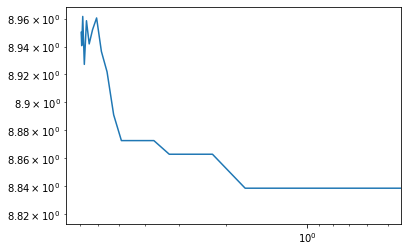

7966.329565127684
7966.329565127684
8037.474723487079
8039.407644944935
8136.21058080861
8065.380695033392
7501.043780822441
7501.043780822441
7501.043780822441
7501.043780822441
7501.043780822441
7501.043780822441
7665.792335306828
7665.792335306828
7563.471652939369
7563.471652939369
7563.471652939369
7563.471652939369
7563.471652939369
7563.471652939369
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7544.5380283747045
7471.843316414

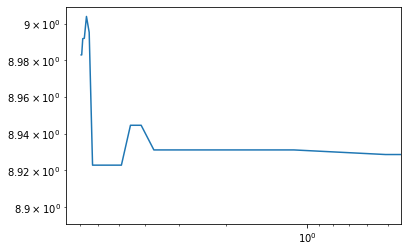

9149.22919032265
8740.657286703145
8738.048621691269
9016.124792023957
9016.124792023957
9016.124792023957
8990.352574293573
8629.609780004412
8629.609780004412
8606.876638106916
8629.609780004412
8629.609780004412
8629.609780004412
8205.870645638499
8233.4469972555
8233.4469972555
8239.866837974187
8239.866837974187
8218.872358841056
8218.872358841056
8218.872358841056
8218.872358841056
8218.872358841056
8218.872358841056
8218.872358841056
8218.872358841056
8218.872358841056
8182.885048043539
8182.885048043539
8182.885048043539
8182.885048043539
8182.885048043539
8182.885048043539
8182.885048043539
8182.885048043539
8182.885048043539
8182.885048043539
8182.885048043539
8182.885048043539
8182.885048043539
8182.885048043539
8103.6518046747915
8103.6518046747915
8103.6518046747915
8103.6518046747915
8103.6518046747915
8103.6518046747915
8103.6518046747915
8103.6518046747915
8103.6518046747915
8103.6518046747915
8103.6518046747915
8103.6518046747915
8103.6518046747915
8103.6518046747915
8

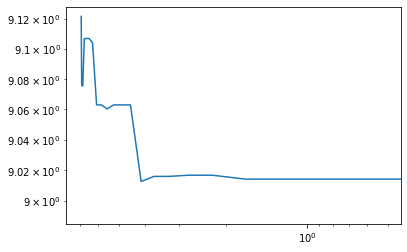

8191.999265844494
7873.2000609628985
7873.2000609628985
7726.697061770565
7902.381468136233
8221.835403386533
8039.539428692727
8039.539428692727
8195.81922383332
8062.333261389734
8318.644570090659
7633.869482535936
7633.869482535936
7633.869482535936
7633.869482535936
7633.869482535936
7633.869482535936
7399.120919746778
7399.120919746778
7399.120919746778
7399.120919746778
7399.120919746778
7399.120919746778
7399.120919746778
7399.120919746778
7399.120919746778
7399.120919746778
7399.120919746778
7399.120919746778
7399.120919746778
7399.120919746778
7399.120919746778
7399.120919746778
7399.120919746778
7399.120919746778
7399.120919746778
7391.40020201512
7391.40020201512
7391.40020201512
7391.40020201512
7316.524372905904
7316.524372905904
7316.524372905904
7316.524372905904
7316.524372905904
7316.524372905904
7316.524372905904
7316.524372905904
7316.524372905904
7316.524372905904
7316.524372905904
7316.524372905904
7316.524372905904
7316.524372905904
7316.524372905904
7316.52437290

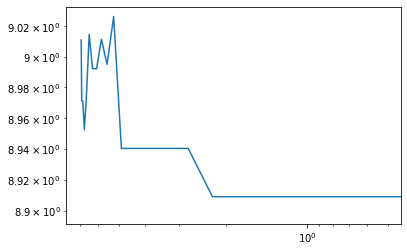

8189.684772059099
8127.851555234473
7940.65343886302
7829.228266864441
7894.064601494296
7789.734447996693
7789.734447996693
7875.516664135362
7945.982232034374
7899.0522428371705
7899.0522428371705
7791.61835322729
7791.61835322729
7687.498541790152
7687.498541790152
7702.736598587033
7644.412918361442
7644.412918361442
7644.412918361442
7644.412918361442
7644.412918361442
7644.412918361442
7644.412918361442
7644.412918361442
7644.412918361442
7644.412918361442
7644.412918361442
7644.412918361442
7644.412918361442
7644.412918361442
7644.412918361442
7644.412918361442
7472.38560562105
7472.38560562105
7472.38560562105
7472.38560562105
7472.38560562105
7472.38560562105
7472.38560562105
7472.38560562105
7472.38560562105
7472.38560562105
7472.38560562105
7472.38560562105
7472.38560562105
7472.38560562105
7472.38560562105
7472.38560562105
7472.38560562105
7472.38560562105
7472.38560562105
7472.38560562105
7472.38560562105
7472.38560562105
7472.38560562105
7472.38560562105
7472.38560562105


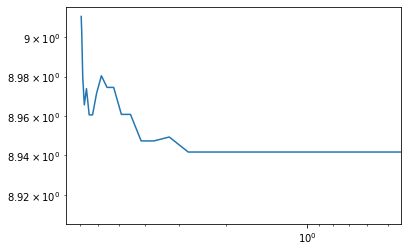

7546.7435868578805
7122.415274479217
7217.7752918447095
6363.799507850735
6381.989775722204
6468.23235618158
6269.867506135893
6103.827114050799
6576.362436454705
6576.362436454705
6325.329157621392
6466.729965439089
6507.972033472164
6507.972033472164
6492.811136579766
6436.603249815572
6376.665714421166
6376.665714421166
6333.257380855706
6333.257380855706
6292.176812593758
6292.176812593758
6292.176812593758
6292.176812593758
6251.972758114253
6212.763380342476
6212.763380342476
6212.763380342476
6212.763380342476
6212.763380342476
6212.763380342476
6212.763380342476
6212.763380342476
6212.763380342476
6212.763380342476
6212.763380342476
6212.763380342476
6212.763380342476
6212.763380342476
6212.763380342476
6212.763380342476
6212.763380342476
6212.763380342476
6212.763380342476
6212.763380342476
6212.763380342476
6212.763380342476
6212.763380342476
6212.763380342476
6212.763380342476
6077.900290782362
6077.900290782362
6077.900290782362
6077.900290782362
6077.900290782362
6077.9002

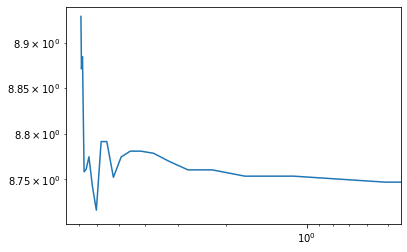

8040.911472415185
7308.461163569292
7219.157358487318
7308.461163569292
7224.439258601504
7433.680989847162
7433.680989847162
7434.995105727903
7439.382589400176
7090.661397986619
7019.721295026581
7019.721295026581
7019.721295026581
6983.219523360115
6983.219523360115
6990.415589540179
6990.415589540179
6990.415589540179
6990.415589540179
6990.415589540179
6990.415589540179
6983.219523360115
6983.219523360115
6962.216549039771
6962.216549039771
6962.216549039771
6962.216549039771
6787.57069966728
6787.57069966728
6787.57069966728
6787.57069966728
6787.57069966728
6646.359133742348
6646.359133742348
6646.359133742348
6646.359133742348
6646.359133742348
6639.995344213
6639.995344213
6639.995344213
6639.995344213
6639.995344213
6639.995344213
6639.995344213
6639.995344213
6639.995344213
6639.995344213
6639.995344213
6639.995344213
6639.995344213
6639.995344213
6639.995344213
6639.995344213
6639.995344213
6639.995344213
6639.995344213
6639.995344213
6639.995344213
6639.995344213
6639.9953

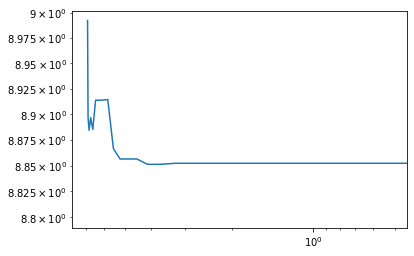

7392.318254400463
6960.585702636403
6960.585702636403
7082.193421237343
7220.784954969566
7258.399420469973
7236.152369818114
7236.152369818114
7236.152369818114
6953.535955663668
6975.86636040127
6975.86636040127
6975.86636040127
6975.86636040127
6975.86636040127
6975.86636040127
6975.86636040127
6975.86636040127
6975.86636040127
6975.86636040127
6975.86636040127
6785.220107347304
6785.220107347304
6785.220107347304
6785.220107347304
6785.220107347304
6745.731544481978
6745.731544481978
6745.731544481978
6745.731544481978
6745.731544481978
6745.731544481978
6745.731544481978
6745.731544481978
6745.731544481978
6745.731544481978
6735.617838133016
6735.617838133016
6735.617838133016
6735.617838133016
6735.617838133016
6735.617838133016
6735.617838133016
6735.617838133016
6735.617838133016
6735.617838133016
6735.617838133016
6735.617838133016
6735.617838133016
6735.617838133016
6735.617838133016
6735.617838133016
6735.617838133016
6735.617838133016
6735.617838133016
6735.617838133016
673

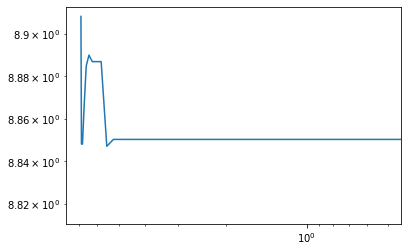

6752.261523137671
7021.341428442072
6752.261523137671
7098.653693766937
7251.109018747056
7098.653693766937
7074.588626977028
7082.455602793174
7138.433990698807
6946.441866945868
6911.557009125366
6703.910001993008
6490.18478711214
6490.18478711214
6495.120788821853
6495.120788821853
6495.120788821853
6495.120788821853
6495.120788821853
6495.120788821853
6495.120788821853
6495.120788821853
6495.120788821853
6495.120788821853
6495.120788821853
6495.120788821853
6495.120788821853
6495.120788821853
6495.120788821853
6490.18478711214
6490.18478711214
6490.18478711214
6464.380439467234
6464.380439467234
6464.380439467234
6464.380439467234
6464.380439467234
6437.072172123076
6437.072172123076
6437.072172123076
6437.072172123076
6437.072172123076
6437.072172123076
6437.072172123076
6437.072172123076
6437.072172123076
6437.072172123076
6437.072172123076
6437.072172123076
6376.234138079707
6376.234138079707
6376.234138079707
6376.234138079707
6376.234138079707
6376.234138079707
6214.0091479497

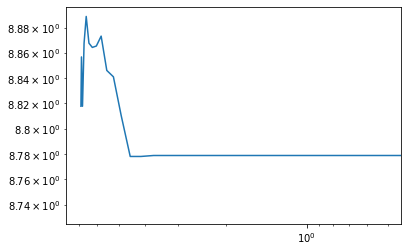

7240.159050999446
7194.8966662702705
6747.4598119479715
6747.4598119479715
7323.068618067939
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6747.4598119479715
6723.1168547895995
6723.1168547895995
6723.1168547895995
6723.1168547895995
6723.1168547895995
6723.1168547895995
6723.1168547895995
6723.1168547895995
6723.1168547895995
6723.1168547895995
6723.1168547895995
6723.1168547895995
6723.1168547895995
6723.1168547895995
6723.1168547895995
6723.116854789

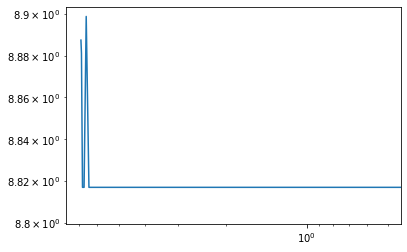

8149.500157604198
8149.500157604198
8463.684388890291
8350.939661332417
8444.95086173665
8322.46426140815
8352.301054243699
8352.301054243699
8411.214482526413
8411.214482526413
8411.214482526413
8311.219863690882
8173.3238835159
8173.3238835159
8322.956823944494
8210.21209638662
8210.21209638662
8210.21209638662
8163.666050072264
8163.666050072264
8163.666050072264
8163.666050072264
7387.317153213325
7387.317153213325
7387.317153213325
7387.317153213325
7387.317153213325
7387.317153213325
7387.317153213325
7387.317153213325
7387.317153213325
7387.317153213325
7387.317153213325
7387.317153213325
7387.317153213325
7387.317153213325
7387.317153213325
7189.598761365703
7189.598761365703
7189.598761365703
7189.598761365703
7189.598761365703
7189.598761365703
7189.598761365703
7189.598761365703
7189.598761365703
7189.598761365703
7189.598761365703
7189.598761365703
7189.598761365703
7166.0197583556
7166.0197583556
7166.0197583556
7166.0197583556
7166.0197583556
7166.0197583556
7166.01975835

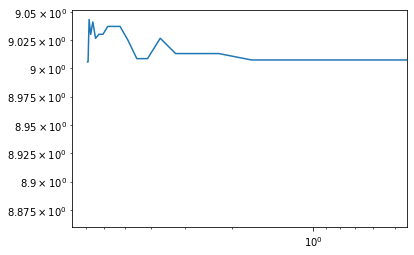

8490.34386182786
8490.34386182786
7740.3650355208465
7862.990660644449
8137.893346028515
8644.956882517965
8640.664289831591
8257.273744073978
8140.209596928434
8140.209596928434
8080.46826316396
8197.697762026228
7903.797244287296
7541.375740185035
7535.3834443846445
7535.3834443846445
7535.3834443846445
7535.3834443846445
7535.3834443846445
7520.215392049868
7520.215392049868
7520.215392049868
7520.215392049868
7520.215392049868
7411.285169002728
7411.285169002728
7408.246772566827
7408.246772566827
7408.246772566827
7408.246772566827
7408.246772566827
7408.246772566827
7408.246772566827
7408.246772566827
7408.246772566827
7408.246772566827
7408.246772566827
7408.246772566827
7408.246772566827
7408.246772566827
7408.246772566827
7408.246772566827
7408.246772566827
7408.246772566827
7408.246772566827
7408.246772566827
7408.246772566827
7408.246772566827
7408.246772566827
7408.246772566827
7351.840288550389
7351.840288550389
7351.840288550389
7351.840288550389
7351.840288550389
7351.84

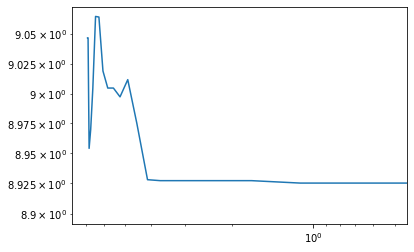

8547.177657708466
8599.417774174575
8679.966399703615
8696.418951498272
8745.422947954265
8514.548077626918
8583.745402148492
8672.285209116986
8173.8750498292
8173.8750498292
7851.679591528699
7851.679591528699
7851.679591528699
7851.679591528699
7851.679591528699
7851.679591528699
7849.758318324418
7849.758318324418
7849.758318324418
7849.758318324418
7849.758318324418
7849.758318324418
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838044
7780.493654838

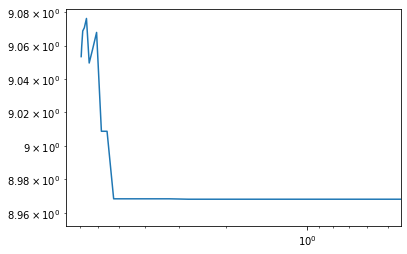

7551.175768019046
7377.5172653652935
7418.31077314462
7518.547602887035
7418.31077314462
7063.464713889265
7063.464713889265
7175.254635012574
7175.254635012574
7193.796795283179
7193.796795283179
7193.796795283179
7193.796795283179
7193.796795283179
7097.894910125739
7054.710681736029
6868.024862314622
6868.024862314622
6868.024862314622
6868.024862314622
6868.024862314622
6868.024862314622
6868.024862314622
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984514784
6501.404984

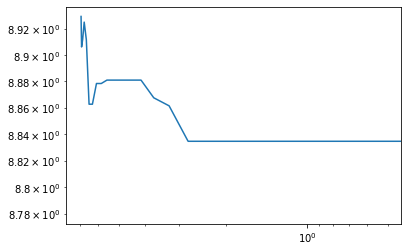

7798.884458958646
7783.296774488292
7977.895106660551
7846.957428992226
8056.773139085789
7897.8907182474695
7865.034653460603
7890.3541513339405
7764.570938474211
7764.570938474211
7693.984206017061
7511.80332813083
7511.80332813083
7252.712624117344
7305.142858352273
7305.142858352273
7305.142858352273
7305.142858352273
7277.619419724821
7277.619419724821
7277.619419724821
7230.262188169463
7230.262188169463
7230.262188169463
7230.262188169463
7230.262188169463
7230.262188169463
7230.262188169463
7230.262188169463
7230.262188169463
7230.262188169463
7230.262188169463
7230.262188169463
7230.262188169463
7230.262188169463
7230.262188169463
7230.262188169463
7230.262188169463
7230.262188169463
7230.262188169463
7230.262188169463
7230.262188169463
7230.262188169463
7230.262188169463
7230.262188169463
7230.262188169463
7230.262188169463
7230.262188169463
7230.262188169463
6940.059747688448
6940.059747688448
6940.059747688448
6940.059747688448
6940.059747688448
6940.059747688448
6940.05974

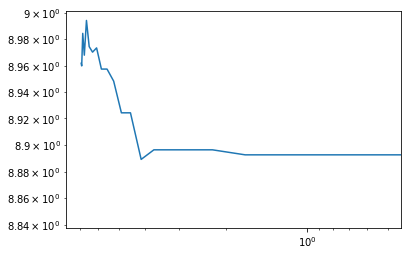

8132.404305622198
8067.310693769621
8228.916444048093
8186.373816655339
7924.420588295505
8120.148100947223
8033.197965223825
8120.148100947223
8208.503719155968
8107.164967711513
8107.164967711513
8268.770717989986
8268.770717989986
8268.770717989986
8119.436643520455
8119.436643520455
8119.436643520455
8119.436643520455
8119.436643520455
8119.436643520455
8119.436643520455
8119.436643520455
8119.436643520455
7992.853465317399
7992.853465317399
7992.853465317399
7992.853465317399
7992.853465317399
7992.853465317399
7992.853465317399
7992.853465317399
7992.853465317399
7791.358812639922
7791.358812639922
7791.358812639922
7791.358812639922
7791.358812639922
7791.358812639922
7791.358812639922
7791.358812639922
7791.358812639922
7791.358812639922
7791.358812639922
7791.358812639922
7791.358812639922
7791.358812639922
7791.358812639922
7791.358812639922
7791.358812639922
7791.358812639922
7791.358812639922
7791.358812639922
7791.358812639922
7791.358812639922
7791.358812639922
7664.77563

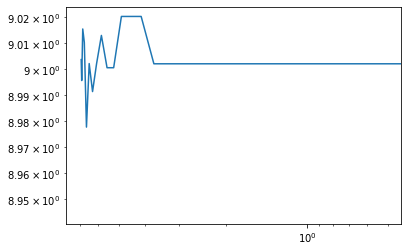

8154.5069359954305
8113.272315530028
8312.809740839635
8253.62487404503
8253.56735619516
8344.787692717398
8237.140872708336
8396.521615347516
8406.56665581958
7897.1754992638525
7850.848575237462
7816.624905083679
7301.578366875431
7301.578366875431
7301.578366875431
7291.960770075418
7291.960770075418
7218.753656249253
7223.353922711769
7223.353922711769
7218.753656249253
7218.753656249253
7218.753656249253
7218.753656249253
7218.753656249253
7218.753656249253
7218.753656249253
7218.753656249253
7218.753656249253
7218.753656249253
7218.753656249253
7218.753656249253
7218.753656249253
7218.753656249253
7059.598183975344
7059.598183975344
7059.598183975344
7059.598183975344
7059.598183975344
7059.598183975344
7059.598183975344
7059.598183975344
7027.673412627194
7027.673412627194
7027.673412627194
7027.673412627194
7027.673412627194
7027.673412627194
7027.673412627194
7027.673412627194
7027.673412627194
7027.673412627194
7027.673412627194
7027.673412627194
7027.673412627194
7027.673412

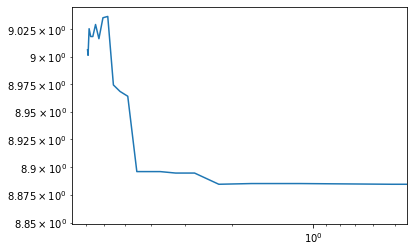

7501.237556322563
6727.914771995955
6649.763520909589
7073.608667856736
7060.934482189098
6329.198352014811
6329.198352014811
6329.198352014811
6329.198352014811
7060.934482189098
7062.940975015555
6357.246140009347
6357.246140009347
6357.246140009347
6357.246140009347
6357.246140009347
6357.246140009347
5872.185099709104
5872.185099709104
5872.185099709104
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.580539202214
5828.58053

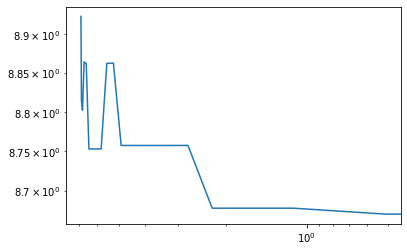

8061.275423406915
8127.754970664676
8112.970717738525
8372.732884948606
8168.468957099096
8456.60942913457
8467.61679942922
7952.679635400689
7952.679635400689
7954.686687842905
8088.185828615873
8250.35689192335
8187.673912079764
7951.984941691228
7989.771376684959
7951.984941691228
7951.984941691228
7951.984941691228
7951.984941691228
7951.777247441368
7951.777247441368
7951.777247441368
7890.977434355879
7890.977434355879
7890.977434355879
7890.977434355879
7890.977434355879
7890.977434355879
7890.977434355879
7890.977434355879
7890.977434355879
7890.977434355879
7888.148033442888
7888.148033442888
7888.148033442888
7888.148033442888
7878.5790948177955
7878.5790948177955
7878.5790948177955
7878.5790948177955
7878.5790948177955
7878.5790948177955
7878.5790948177955
7878.5790948177955
7878.5790948177955
7878.5790948177955
7870.863888128991
7870.863888128991
7870.863888128991
7870.863888128991
7870.863888128991
7870.863888128991
7786.891061117517
7786.891061117517
7786.891061117517
778

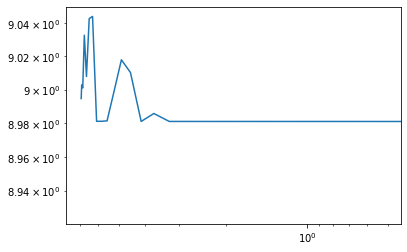

8731.122339993535
8403.352818442603
8481.338043426726
8251.090475712588
8266.56919868276
8488.860493082482
8337.917293082306
8282.359161781473
8474.921445738579
8243.088869804838
8335.012547438768
7957.753297364259
7957.753297364259
7957.753297364259
7957.753297364259
7957.753297364259
7791.010850956964
7791.010850956964
7791.010850956964
7791.010850956964
7791.010850956964
7791.010850956964
7791.010850956964
7791.010850956964
7791.010850956964
7789.324205325034
7789.324205325034
7789.324205325034
7789.324205325034
7789.324205325034
7789.324205325034
7789.324205325034
7789.324205325034
7662.731203453644
7662.731203453644
7662.731203453644
7662.731203453644
7662.731203453644
7662.731203453644
7662.731203453644
7662.731203453644
7662.731203453644
7662.731203453644
7662.731203453644
7662.731203453644
7662.731203453644
7662.731203453644
7662.731203453644
7662.731203453644
7662.731203453644
7662.731203453644
7662.731203453644
7662.731203453644
7662.731203453644
7662.731203453644
7662.731203

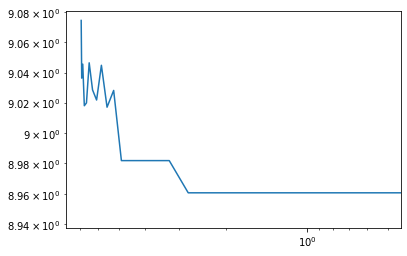

optim_path: [('Tallahassee', (594.8, 434.8)), ('Atlanta', (585.6, 376.8)), ('Hartford', (719.6, 205.2)), ('Madison', (500.8, 217.6)), ('Salem', (80.0, 139.2)), ('Sacramento', (68.4, 254.0)), ('Salt Lake City', (204.0, 243.2)), ('Jackson', (501.6, 409.6)), ('Boise', (159.6, 182.8)), ('Montgomery', (559.6, 404.8)), ('Little Rock', (469.2, 367.2)), ('Austin', (389.2, 448.4)), ('Oklahoma City', (392.8, 356.4)), ('Indianapolis', (548.0, 272.8)), ('Albany', (702.0, 193.6)), ('Phoenix', (179.6, 371.2)), ('Lansing', (563.6, 216.4)), ('Richmond', (673.2, 293.6)), ('Des Moines', (447.6, 246.0)), ('Saint Paul', (451.6, 186.0)), ('Denver', (293.6, 274.0)), ('Harrisburg', (670.8, 244.0)), ('Trenton', (698.8, 239.6)), ('Boston', (738.4, 190.8)), ('Providence', (735.2, 201.2)), ('Columbia', (632.4, 364.8)), ('Raleigh', (662.0, 328.8)), ('Nashville', (546.4, 336.8)), ('Baton Rouge', (489.6, 442.0)), ('Columbus', (590.8, 263.2))]
optim_value: 5828.580539202214


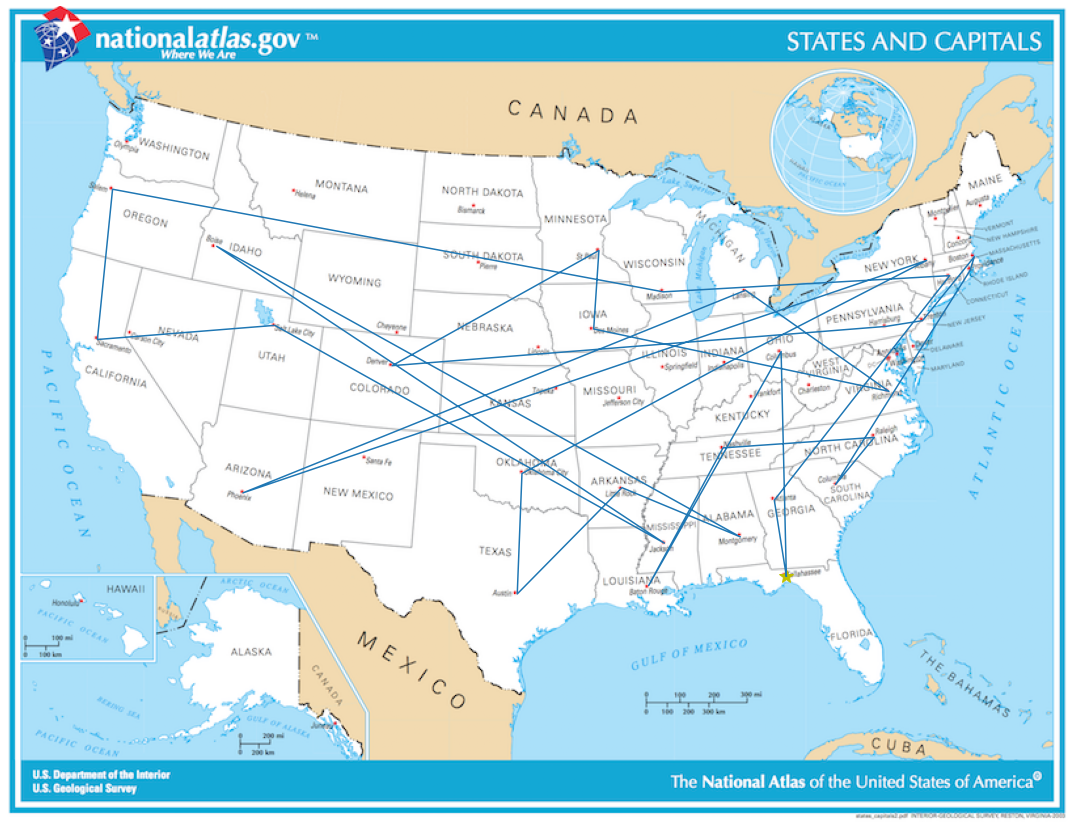

In [ ]:
searching_best()

## Open questions

We propose here a set of open-ended questions, which will provide opportunities to expand the discussion in your report. 


0. How can you find the longest path instead of the shortest path, explain your idea

0. Explain why the cooling procedure and temperature schedule is key to the success of the minimisation

0. Imagine that we now slightly complicate the question: Travelling coast-to-coast is difficult in winter time, due to frequent road closures in the central states (snow conditions). How could you modify the algorithm such that we avoid as much as possible crossing the country transversally ?

0. Comment briefly on possible other scientific topics where simulated annealing could be useful, and provide one or two references
 


Answers : 
    
0. We set $$ P = e^{ - \left( d_{old} - d_{new}  \right) / T } $$ and then keep the rest of the algorithm the same

1. Because the cooling procedure and temperature schedule determines the value of $P$, which is key to determine whether to accept or reject the new solution even it is a bit worse than the current one. And this is key in the algorithm that we can somehow avoid local minimum value.

2. We can make the distance between cities with related closures $inf$, therefore we can avoid crossing the country transversally since the path distance including those would be very large and then rejected.

3. The SA algorithm could be applied to scheduling problem such as allocating the flowshop or machine, and designing network which requires faster transmission speed. Those are from reference:

@article{dolan1989process,
  title={Process optimization via simulated annealing: application to network design},
  author={Dolan, WB and Cummings, PT and LeVan, MD},
  journal={AIChE Journal},
  volume={35},
  number={5},
  pages={725--736},
  year={1989},
  publisher={Wiley Online Library}
}

@article{koulamas1994survey,
  title={A survey of simulated annealing applications to operations research problems},
  author={Koulamas, Christos and Antony, SR and Jaen, R},
  journal={Omega},
  volume={22},
  number={1},
  pages={41--56},
  year={1994},
  publisher={Elsevier}
}